In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

This is a template code with instructions on how to create and use the GNN model.   
This notebook skeleton uses train only
Straight away use test for the test

For code without the instructions, look at `00_06_barebones_train_test.ipynb`  

# Imports 

In [18]:
import pandas as pd
import numpy as np
import torch

from utils.setup_nodes import create_edge_lists
from utils.graph_helpers import train_model_without_test, plot_train_val_loss, final_evaluation
from utils.graph_model import Base_GNN_Model
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, evaluate_recall

# Set seed

In [3]:
seed_everything()

# Set variables 

1. `user_split` is either `train_test_valid` or `train_test`
2. `prod_embed_name` is the name of the embeddings to be used for product
3. `user_embed_name` is the name of the embeddings to be used for user (note the files will be preprended with train/test/split)
4. `*_dir` is the respective file paths
5. `device` cuda or cpu depending on your machine
6. `*_cols` the cols to load from the dataframes (change if you need to change the features)
7. `fill_users` the method to fill up the new user data (zero or mean)

In [5]:
user_split = "train_test"
prod_embed_name = "meta_features_512"
user_embed_name = "user_reviews_features_512"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

fill_users = "zero"

# Load data

Take special attention to what is being loaded as a the test set.  
Remember if you want test data, set the value of `user_split` to `train_test` in the previous cell

Also, I am limiting the number of columns being read in. So edit accordingly to what colum values are needed for the current set up 

If there is more than 1 tensor for the embedding, sugesstion is to do a torch.cat into a single longer tensor first and then carry it on to the next step. So load under different name then join it back to as product_emebdding, train_user_embedding and test_user_embedding

In [6]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [7]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

We need to do a few things
1. Make a super user df - so that all the nodes are inside the graph and the idx would be correct later
2. Set up an index mapping from ids to idx (note that the product index need to be offeset)
3. Concat information to form the product nodes
4. Concat information to form the user nodes - only for the train users, test users need to init as something if they dont exist in train (maybe zero or mean)
5. Create edge list for train and test (using the idx) 

For product nodes, we assume the df has information, less the ids. If there is no information, then change the creation accordingly  

For the user nodes, for users in test but not in train, the current method is to user zero.  
There is also a flag to fill with mean instead 

In [8]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Concat user nodes 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()

## these are users that need to be zero-ed out 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
additional_test_users["embedding"] = list(torch.zeros((len(additional_test_users), test_user_embedding.shape[1])).numpy())
if fill_users == "zero":
    additional_test_users.iloc[:, 1:-1] = 0
elif fill_users == "mean":
    additional_test_users.iloc[:, 1:-1] = train_user_df.iloc[:, 1:].mean()

# Make super user df
user_df = pd.concat([train_user_df, additional_test_users])

In [9]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [10]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [11]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [12]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

This is placed here for clarity 

In [13]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Instantiate the model

Whatever the model is decided, create it here  
ideally assign it to model so easier for the overall run  

The model when instantiating will take in the following variables (based on the default architecture that we are doing)
1. number of users - create extra embeddings for each user
2. number of products - create extra embedding for each product
3. user feature dimensions - size of self created information for users
4. product feature dimensions - size of self created information for products
5. embedding dim - what size the features reduce to (for default base model, this was the same for every place)

If you make any changes, feel free to edit accordingly

Finally don't forget to move the model to gpu 

In [14]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 64

In [15]:
# Instantiate the model
model = Base_GNN_Model(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim)

In [16]:
# move the model 
model.to(device)

Base_GNN_Model(
  (user_embedding): Embedding(474892, 64)
  (product_embedding): Embedding(89060, 64)
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Train the model 

Pass the model, data and all into a loop and let it train 

**WARN**  
The combining of edges is done inside the trianing loop (bipartite back link)

In [19]:
train_losses = train_model_without_test(model, train_edge_index, train_edge_weights, user_nodes, product_nodes, num_epochs = 100)

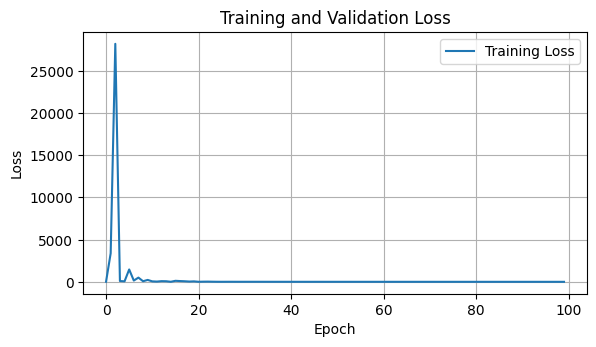

In [20]:
plot_train_val_loss(train_losses)

# Final model performance 

This is simply to load the best model during training and to print that loss  
Has no other purpose 

In [21]:
final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device)

Test loss: 2.7167


# Metrics 

We have two kinds
1. Recall at 10
2. NDCG at 10

The recall takes about ___ mins and will generally be bad   
NDCG is a work in progress so TBC

In [25]:
product_idx_tensor = torch.tensor(list(prod_id_to_idx.values()), dtype=torch.long)

In [ ]:
# recall 
# evaluate_recall(model, test_edge_index, 10, 32, user_nodes, product_nodes, product_idx_tensor, device)

# Show recomendations 

This is just to sample and see what kind of results we get   
I am going to do three kinds of sampling
1. Pure random of the test set 
2. Select test set that have some existance in the training set 
3. Take the test set that dont have existance in the training set but use their user node information 


But first we need to create a reverse mapping that does the offset 
Also need to load up a df to map ids to titles

In [22]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [48]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: Finest Remy Brazilian Deep Wave 100% Unprocessed Virgin Brazilian Hair 4 Bundles 7A Deep Curly Human Hair Extensions (16161616+14, 1B/30 7A)
Product 2: BCQueen Hair 4 bundles Brazilian Ombre Deep Wave with Closure (18"18"18"18"+16Closure)100% Unprocessed Virgin Brazilian Hair Bundles Ombre Deep Curly with Closure Human Hair Extensions T1B/30
Product 3: 5 Piece Perfume Gift Set for Women - Inspired by Victoria's Secret, JC, Ariana Grande, and Rihanna. 0.33Fl.Oz./10Ml.
Product 4: Brazilian Ombre Afro Kinky Curly Drawstring Ponytail Hair 4b4c Three Tone Ombre 1b/4/27 Afro Hair Ponytail Human Hair With Clips Brazilian Virgin Human Hair (16inch, ombre afro ponytail)
Product 5: 3 Bundles with Frontal Body Wave 14 14 14 with 12 Frontal 10A Brazilian Virgin Real Human Hair Bundles with Closure 13x4 Lace Front Wig Natural Color
Product 6: Lovrio Ombre Clip Ins Kinkys Curly Hair Extensions Brazilian Virgin Human Hair Tone Natural Black Fading into Caramel Blonde Color 7 Pieces 120g KC

In [24]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [ ]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: Finest Remy Brazilian Deep Wave 100% Unprocessed Virgin Brazilian Hair 4 Bundles 7A Deep Curly Human Hair Extensions (16161616+14, 1B/30 7A)
Product 2: BCQueen Hair 4 bundles Brazilian Ombre Deep Wave with Closure (18"18"18"18"+16Closure)100% Unprocessed Virgin Brazilian Hair Bundles Ombre Deep Curly with Closure Human Hair Extensions T1B/30
Product 3: 5 Piece Perfume Gift Set for Women - Inspired by Victoria's Secret, JC, Ariana Grande, and Rihanna. 0.33Fl.Oz./10Ml.
Product 4: 3 Bundles with Frontal Body Wave 14 14 14 with 12 Frontal 10A Brazilian Virgin Real Human Hair Bundles with Closure 13x4 Lace Front Wig Natural Color
Product 5: Brazilian Ombre Afro Kinky Curly Drawstring Ponytail Hair 4b4c Three Tone Ombre 1b/4/27 Afro Hair Ponytail Human Hair With Clips Brazilian Virgin Human Hair (16inch, ombre afro ponytail)
Product 6: Lovrio Ombre Clip Ins Kinkys Curly Hair Extensions Brazilian Virgin Human Hair Tone Natural Black Fading into Caramel Blonde Color 7 Pieces 120g KC

: 

In [26]:
# The boosted way
# This is just to see if existing data (a bit of data leak) can help improve performance 
boosted_additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
boosted_user_df = pd.concat([train_user_df, boosted_additional_test_users])
boosted_user_embed = torch.tensor(np.vstack(boosted_user_df["embedding"].values))
boosted_user_info = torch.tensor(boosted_user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
boosted_user_nodes = torch.cat([boosted_user_embed, boosted_user_info], dim = 1)

In [37]:
user_id = boosted_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: Finest Remy Brazilian Deep Wave 100% Unprocessed Virgin Brazilian Hair 4 Bundles 7A Deep Curly Human Hair Extensions (16161616+14, 1B/30 7A)
Product 2: BCQueen Hair 4 bundles Brazilian Ombre Deep Wave with Closure (18"18"18"18"+16Closure)100% Unprocessed Virgin Brazilian Hair Bundles Ombre Deep Curly with Closure Human Hair Extensions T1B/30
Product 3: 5 Piece Perfume Gift Set for Women - Inspired by Victoria's Secret, JC, Ariana Grande, and Rihanna. 0.33Fl.Oz./10Ml.
Product 4: 3 Bundles with Frontal Body Wave 14 14 14 with 12 Frontal 10A Brazilian Virgin Real Human Hair Bundles with Closure 13x4 Lace Front Wig Natural Color
Product 5: Brazilian Ombre Afro Kinky Curly Drawstring Ponytail Hair 4b4c Three Tone Ombre 1b/4/27 Afro Hair Ponytail Human Hair With Clips Brazilian Virgin Human Hair (16inch, ombre afro ponytail)
Product 6: Lovrio Ombre Clip Ins Kinkys Curly Hair Extensions Brazilian Virgin Human Hair Tone Natural Black Fading into Caramel Blonde Color 7 Pieces 120g KC